# **Coursera Dataset Exploration**

The data was scraped from Coursera’s official website as part of collecting educational content. We will do some exploratory analysis and data visualization.

**Load the data using Pandas**

In [38]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
import plotly.express as px
import plotly.graph_objects as go
sns.set(style='whitegrid')

**Download the data from the Coursera Course Dataset**

In [3]:
data = pd.read_csv('coursea_data.csv', index_col=0)

**Perform data cleaning**

In [4]:
pd.isnull(data).sum()

course_title                0
course_organization         0
course_Certificate_type     0
course_rating               0
course_difficulty           0
course_students_enrolled    0
dtype: int64

In [5]:
data.duplicated().sum()

np.int64(0)

In [6]:
data.duplicated().value_counts()

False    891
Name: count, dtype: int64

Interpretation: We counted the missing and duplicated values. The dataset is complete with no missing data and each course entry is unique

**Checking for outliers**

In [7]:
num = data.select_dtypes(include="number")
Q1 = num.quantile(0.25)
Q3 = num.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

(num.lt(lower) | num.gt(upper)).sum().sort_values(ascending=False)

course_rating    17
dtype: int64

Interpretation: We used the IQR method to identify outliers in numeric columns, we found that 17 course ratings had an unusual value.

**Perform exploratory data analysis**

In [8]:
data.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


In [9]:
data.shape

(891, 6)

Interpretation: This dataset contains 17 features and 891 observations.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 134 to 163
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_title              891 non-null    object 
 1   course_organization       891 non-null    object 
 2   course_Certificate_type   891 non-null    object 
 3   course_rating             891 non-null    float64
 4   course_difficulty         891 non-null    object 
 5   course_students_enrolled  891 non-null    object 
dtypes: float64(1), object(5)
memory usage: 48.7+ KB


The column 'course_students_enrolled' is type object even though but it should be a float. We need to concert enrollment numbers from strings (e.g. "2.5m") to actual number so we can perform mathematical operations on enrollment data

In [11]:
def value_to_float(x: Union[object, float]) -> float:
    """ A function to convert value to a float """
    if type(x) == float:
        return x
    if 'k' in x:
        if len(x) > 1:
            return float(x.replace('k', '')) * 1000
        return 1000.0
    if 'm' in x:
        if len(x) > 1:
            return float(x.replace('m', '')) * 1000000
        return 1000000.0
    return 0

data['course_students_enrolled'] = data['course_students_enrolled'].apply(value_to_float)

In [12]:
data.describe()

,course_rating,course_students_enrolled
count,891.000000,8.910000e+02
mean,4.677329,9.055208e+04
std,0.162225,1.819365e+05
min,3.300000,1.500000e+03
25%,4.600000,1.750000e+04
50%,4.700000,4.200000e+04
75%,4.800000,9.950000e+04
max,5.000000,3.200000e+06


Checking for numeric data

In [13]:
cols = data.columns
num_cols = data._get_numeric_data().columns
num_cols

Index(['course_rating', 'course_students_enrolled'], dtype='object')

Checking for categorical data

In [14]:
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['course_title',
 'course_difficulty',
 'course_Certificate_type',
 'course_organization']

**Top organization with most course count**

We will count courses per organization and rank them and identify which institutions offer the most courses

In [17]:
TOP_N = 15
org_col = 'course_organization'
top_orgs = (
    data[data[org_col].notna()]
    .groupby(org_col)
    .size()
    .sort_values(ascending=False)
    .head(TOP_N)
    .rename("courses_count")
    .reset_index()
    .rename(columns={org_col: "organization"})
)

top_orgs

,organization,courses_count
0,University of Pennsylvania,59
1,University of Michigan,41
2,Google Cloud,34
3,Johns Hopkins University,28
4,Duke University,28
5,"University of California, Irvine",27
6,University of Illinois at Urbana-Champaign,22
7,IBM,22
8,"University of California, Davis",21
9,University of Colorado Boulder,19


### **Data vizualisation**

We will visualize the top organization by course count

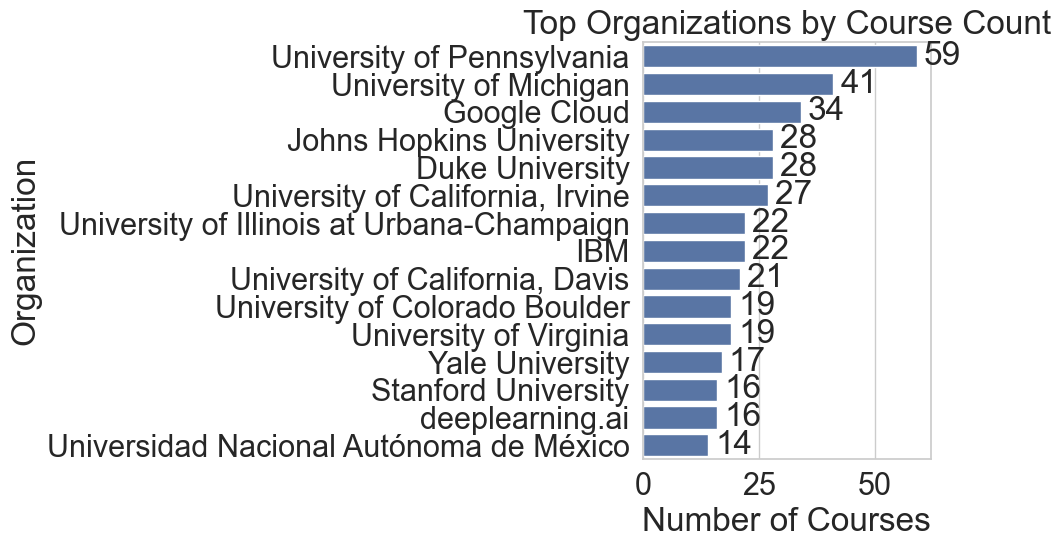

In [32]:
plot_df = top_orgs.sort_values("courses_count", ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_df, x="courses_count", y="organization")

ax.set_title("Top Organizations by Course Count")
ax.set_xlabel("Number of Courses")
ax.set_ylabel("Organization")

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f"{int(width)}",
                (width, p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords="offset points",
                va="center")

plt.tight_layout()
plt.show()

**Average ratings by Organization**

We will calculate the average rating for each organization with more than 10 courses and show which organization produce the highest-rated courses

In [33]:
top_names = top_orgs["organization"].tolist()
rating_col='course_rating'
mask = data[org_col].isin(top_names)
avg_score_top = (
    data.loc[mask]
      .groupby(org_col, dropna=False)[rating_col]
      .mean()
      .rename("avg_score")
      .reset_index()
)

avg_score_top = top_orgs.merge(avg_score_top, how="left",
                               left_on="organization", right_on=org_col) \
                        .drop(columns=[org_col])

avg_score_top

,organization,courses_count,avg_score
0,University of Pennsylvania,59,4.696610
1,University of Michigan,41,4.729268
2,Google Cloud,34,4.582353
3,Johns Hopkins University,28,4.660714
4,Duke University,28,4.664286
5,"University of California, Irvine",27,4.596296
6,University of Illinois at Urbana-Champaign,22,4.654545
7,IBM,22,4.613636
8,"University of California, Davis",21,4.619048
9,University of Colorado Boulder,19,4.668421


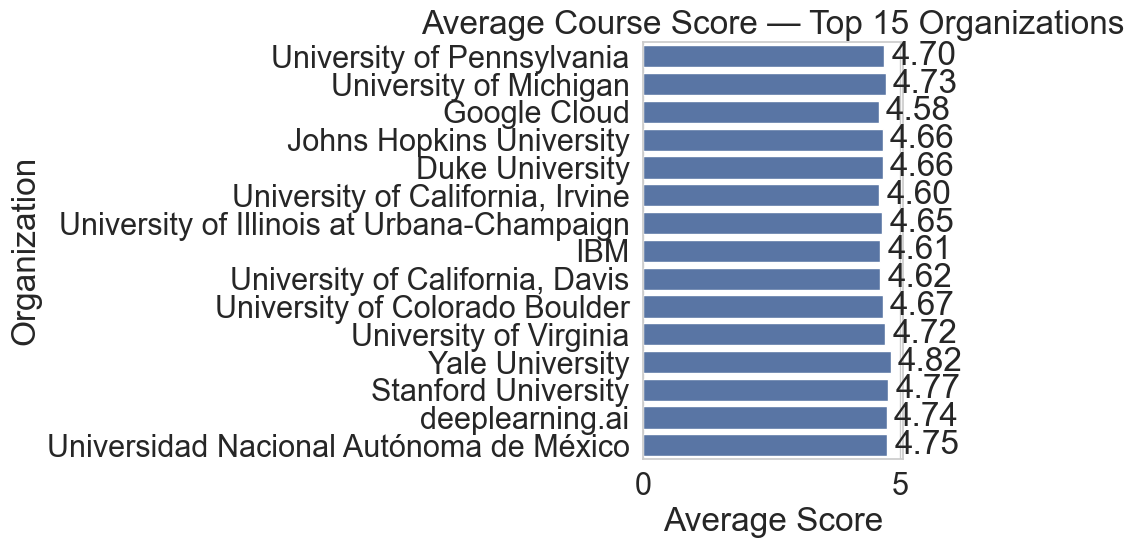

In [34]:
plot_df = avg_score_top.copy()

plot_df["organization"] = pd.Categorical(plot_df["organization"],
                                         categories=top_orgs["organization"].tolist(),
                                         ordered=True)
plot_df = plot_df.sort_values("organization")

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=plot_df, x="avg_score", y="organization")
ax.set_title("Average Course Score — Top 15 Organizations")
ax.set_xlabel("Average Score")
ax.set_ylabel("Organization")

for p in ax.patches:
    width = p.get_width()
    ax.annotate(f"{width:.2f}",
                (width, p.get_y() + p.get_height() / 2),
                xytext=(5, 0), textcoords="offset points",
                va="center")

plt.tight_layout()
plt.show()

**Difficulty vs. Enrollment Analysis**

For the following analysis, we will sum total enrollment by difficulty level and show which difficulty level attract most student

In [24]:
pd.DataFrame({'total_students_enrolled' : data.groupby('course_difficulty').sum()['course_students_enrolled']}).reset_index()

,course_difficulty,total_students_enrolled
0,Advanced,1264400.0
1,Beginner,39921800.0
2,Intermediate,14506300.0
3,Mixed,24989400.0


We will plot a pie chart showing enrollment distribution by difficulty

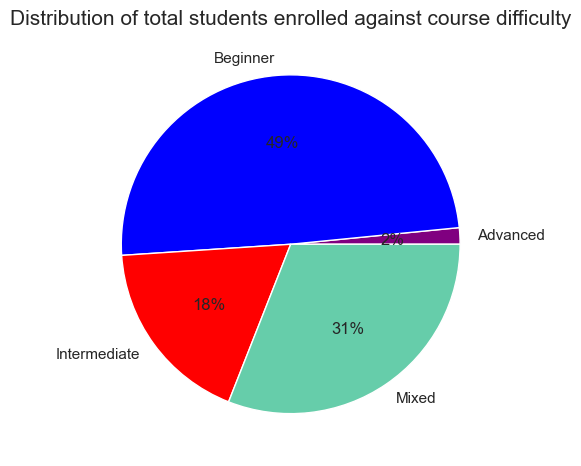

In [26]:
difficulty_totals = data.groupby('course_difficulty')['course_students_enrolled'].sum().reset_index()

my_colors = ['purple','blue','red','mediumaquamarine']
fig, ax = plt.subplots(figsize=(8, 5.5))
ax.pie(difficulty_totals['course_students_enrolled'],labels=difficulty_totals['course_difficulty'],autopct='%1.0f%%',shadow = False, colors=my_colors);
ax.set_title('Distribution of total students enrolled against course difficulty', fontsize=15);

**Certificate Type Impact**

We will calculate average enrollment for each certificate type and show which certificate are most popular

In [27]:
certificate_dict = round(data.groupby('course_Certificate_type')['course_students_enrolled'].mean(), 0).to_dict()
certificate_dict = {k: v for k, v in sorted(certificate_dict.items(), key=lambda item: item[1], reverse=True)}
certificate_dict

{'PROFESSIONAL CERTIFICATE': 190700.0,
 'SPECIALIZATION': 91792.0,
 'COURSE': 87854.0}

We will visualize it with a bar chart comparing certificate types popularity

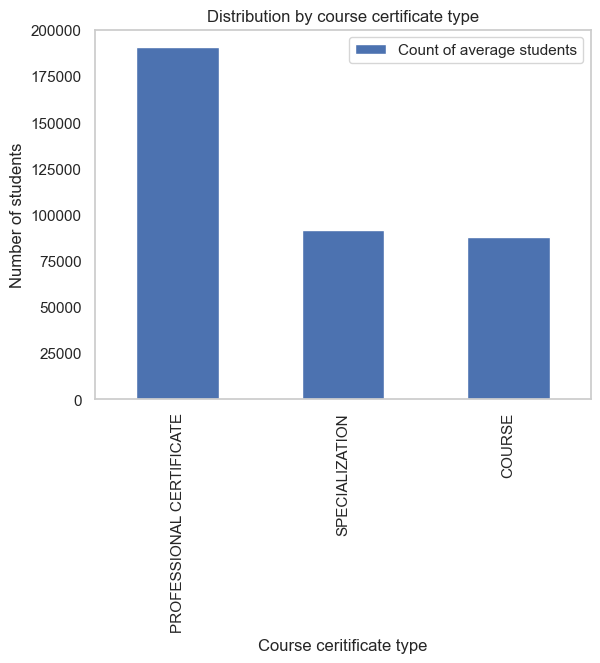

In [28]:
certificate_df = pd.DataFrame({'course_Certificate_type':list(certificate_dict.keys()), 'avg_students':list(certificate_dict.values())})
certificate_df.plot(kind='bar', x='course_Certificate_type', y='avg_students', title='Distribution of students by course certificate type')
plt.rcParams["figure.figsize"] = [12.00, 8.00]
plt.title('Distribution by course certificate type')
plt.xlabel('Course ceritificate type')
plt.ylabel('Number of students')
plt.grid(False)
plt.legend(['Count of average students'], loc='upper right')
plt.show();

**Most popular courses**

We will identify and visualize top 15 courses by enrollment

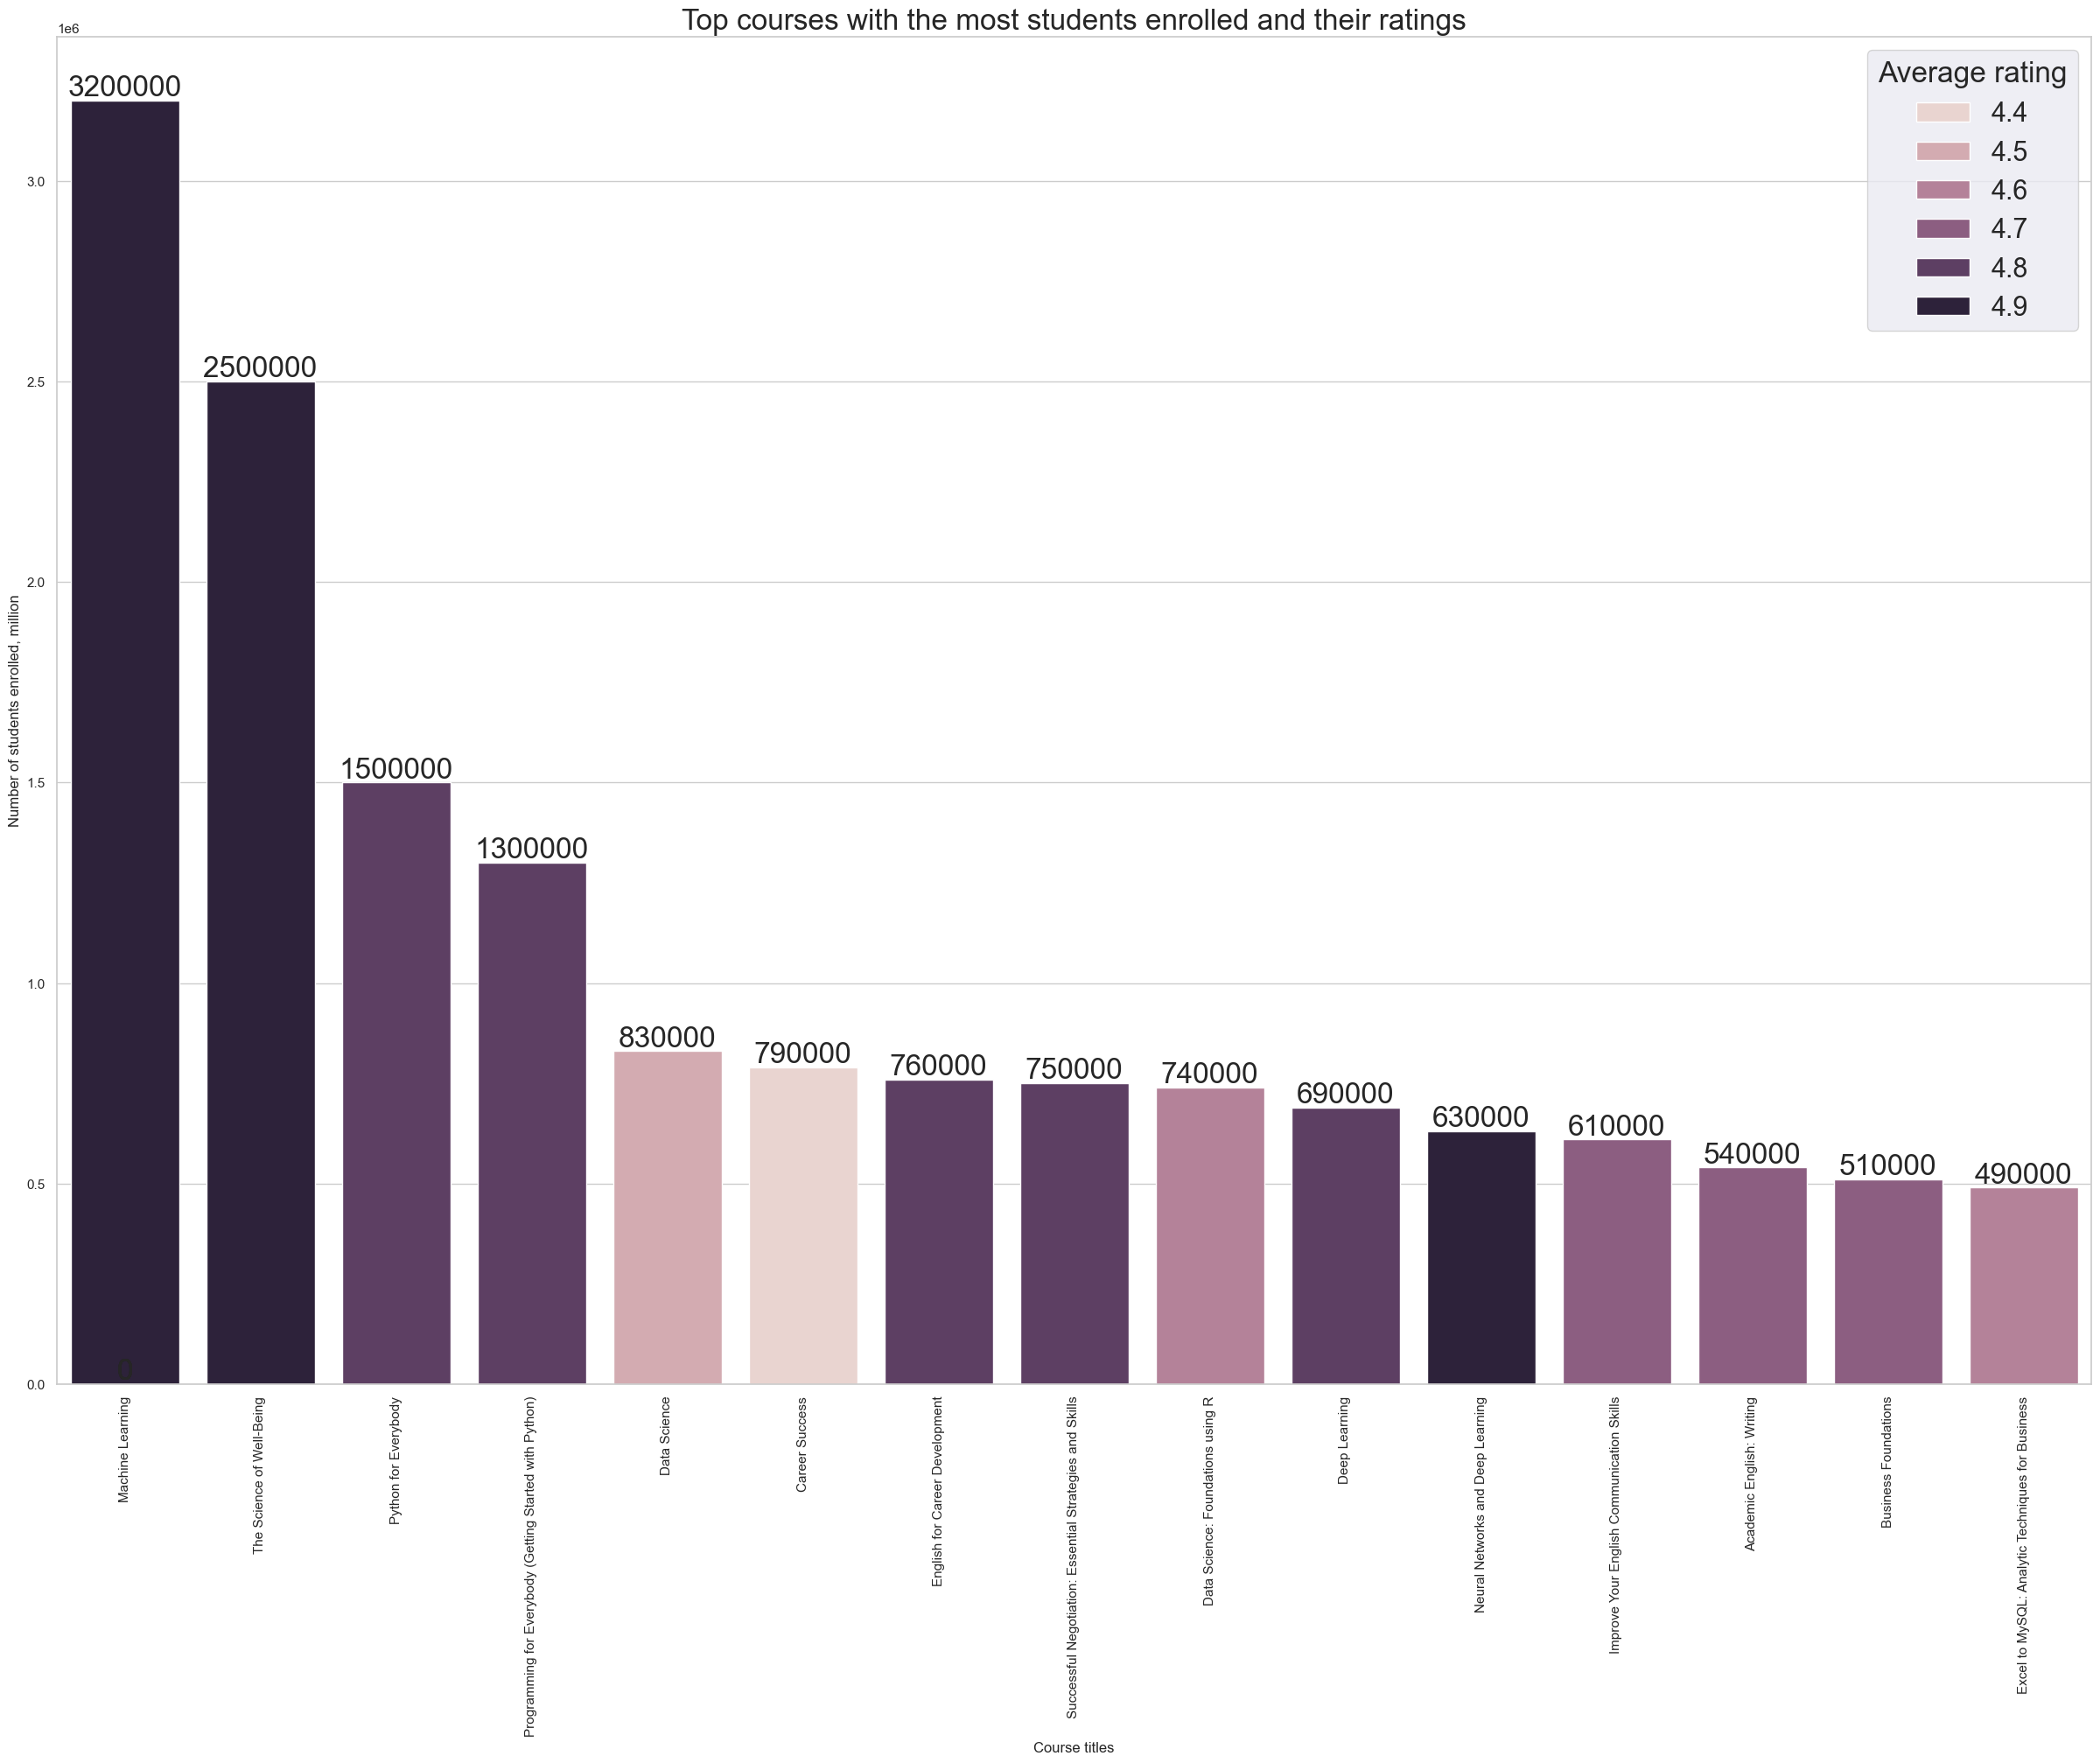

In [ ]:
ten_most_popular_courses_data=data.nlargest(15, ['course_students_enrolled'])

plt.figure(figsize=(30,20))
bar_plot = sns.barplot(x="course_title" ,y="course_students_enrolled",hue="course_rating",data=ten_most_popular_courses_data)
sns.set_style("whitegrid")
sns.set(font_scale = 2)
bar_plot.legend(loc=1, title='Average rating')
plt.rcParams['axes.facecolor'] = 'white'
plt.xlabel('Course titles')
plt.xticks(rotation=90)
plt.ylabel('Number of students enrolled, million')
plt.title("Top courses with the most students enrolled and their ratings")

for value in bar_plot.patches:  
    bar_plot.annotate(format(value.get_height(), '.0f'), (value.get_x() + value.get_width() / 2., value.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

**Corralation Analysis**

We will calculate correlation between numeric variables and show relationship strengh between course ratings and enrollment numbers

                          course_rating  course_students_enrolled
course_rating                   1.00000                   0.07109
course_students_enrolled        0.07109                   1.00000


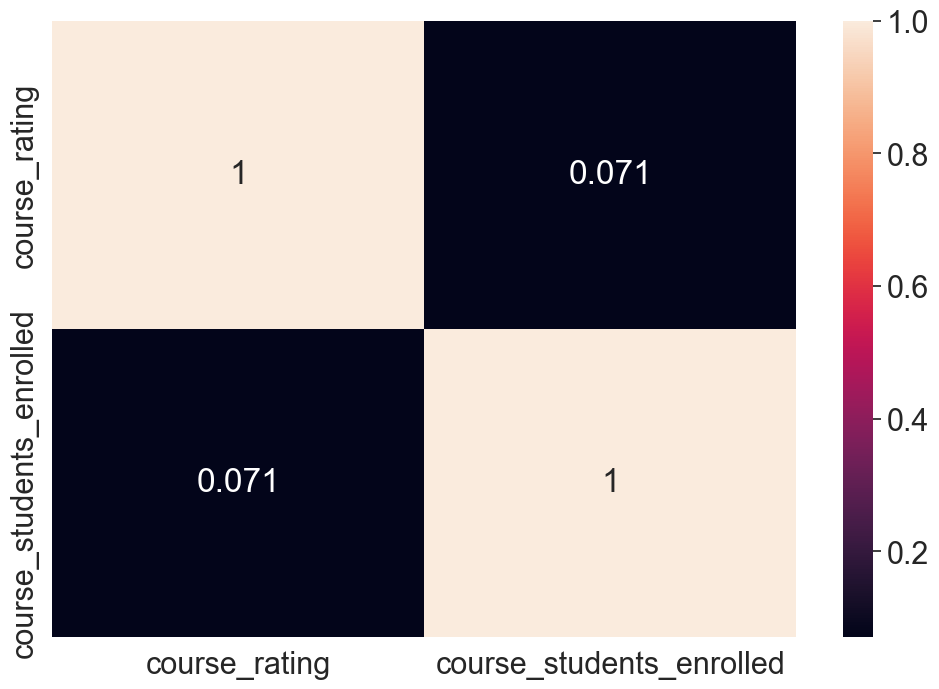

In [31]:
numeric_data = data.select_dtypes(include=[np.number])
print(numeric_data.corr())
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

**Course difficulty distributions**

Next, we’ll analyze how course difficulty and certification types relate to the number of courses, and identify which keywords attract learners. The countplot below shows the distribution of courses across different difficulty levels.

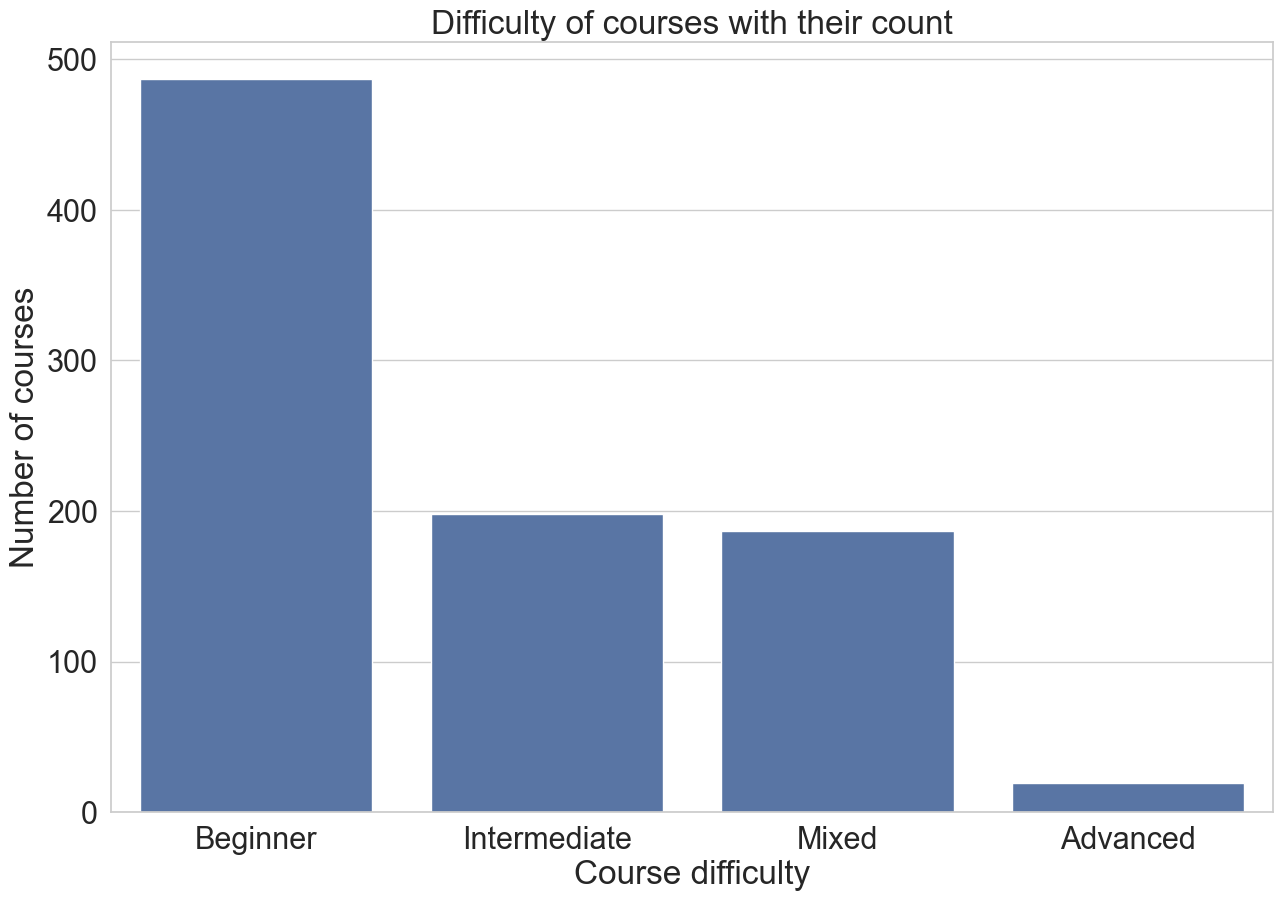

In [35]:
plt.figure(figsize=(15,10)) 
sns.countplot(x='course_difficulty', data=data)
sns.set_style("whitegrid")
plt.xlabel('Course difficulty')
plt.ylabel('Number of courses')
plt.title("Difficulty of courses with their count");

**Interactive graph: Course Rating vs Enrollment**

Please run this code block and open the saved.html file on your browser

In [ ]:
def value_to_float(x):
    if 'k' in str(x).lower():
        return float(str(x).replace('k', '')) * 1000
    elif 'm' in str(x).lower():
        return float(str(x).replace('m', '')) * 1000000
    return float(x)

data['course_students_enrolled'] = data['course_students_enrolled'].apply(value_to_float)

fig = px.scatter(data, 
                 x='course_rating', 
                 y='course_students_enrolled',
                 size='course_students_enrolled',
                 color='course_difficulty',
                 hover_name=data.index,
                 hover_data=['course_organization', 'course_Certificate_type'],
                 title='Course Rating vs Enrollment by Difficulty',
                 labels={'course_rating': 'Course Rating', 
                        'course_students_enrolled': 'Students Enrolled'})

fig.update_layout(
    width=800,
    height=600,
    title_x=0.5,
    font_size=12
)

fig.write_html("bubble_chart.html")
print("✅ Bubble chart saved as 'bubble_chart.html'")
print("📊 Open the HTML file in your browser to view the interactive chart!")
print(f"📈 Chart shows {len(data)} courses with ratings from {data['course_rating'].min():.1f} to {data['course_rating'].max():.1f}")

✅ Bubble chart saved as 'bubble_chart.html'
📊 Open the HTML file in your browser to view the interactive chart!
📈 Chart shows 891 courses with ratings from 3.3 to 5.0


**Provide suggestions for how your analysis can be improved**

Deeper Analysis:

- Compare average course ratings across difficulty levels

- Analyze enrollment patterns over time

Statistical Testing:

- Evaluate if difficulty level impacts enrollment (t-test)

- Assess whether certificate type influences enrollment (chi-square test)